# Assignment


<pre><font size=6>Spoken Digit Recognition</font></pre>

<pre>
In this notebook, You will do Spoken Digit Recognition. 

Input - speech signal, output - digit number



It contains  

1. Reading the dataset. and Preprocess the data set. Detailed instrctions are given below. You have to write the code in the same cell which contains the instrction. 
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List of we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>

</pre>

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 19.2MB/s 


In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score


import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from keras import backend as K
from tqdm import tqdm

# import tensorflow_addons as tfa





In [40]:
%load_ext tensorboard
import datetime
!rm -rf ./logs/

def warn(*args, **kwargs):
  pass
import warnings
warnings.warn = warn


We shared recordings.zip, please unzip those. 

In [ ]:
# !wget --header="Host: doc-10-7k-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8,la;q=0.7" --header="Cookie: AUTH_e6r7g654r08n4c7rvpdb3hggohuuimpl=14748004131253493613|1618294350000|vnbtageljgc7ne0ea7eqvugi1tqi080f" --header="Connection: keep-alive" "https://doc-10-7k-docs.googleusercontent.com/docs/securesc/ir88vhfas868utof5nd7gfa59g7jlumj/7hjeq0fs1u613rjir11ijjbc21pvc7e1/1618294575000/00484516897554883881/14748004131253493613/17YGQheavMbM6aeHYjUcGssXfb7eQHo1z?e=download&authuser=0" -c -O 'recordings.zip'

In [94]:
!unzip recordings.zip

In [3]:
#read the all file names in the recordings folder given by us
#(if you get entire path, it is very useful in future)
#save those files names as list in "all_files"
all_files = []
all_file_paths = []

for fileName in os.listdir("recordings"):
  all_file_paths.append(os.path.join("recordings",fileName))
  all_files.append(fileName)


<font size=4>Grader function 1 </font>

In [4]:
def grader_files():
    temp = len(all_files)==2000
    temp1 = all([x[-3:]=="wav" for x in all_files])
    temp = temp and temp1
    return temp
grader_files()

True

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

In [5]:
#Create a dataframe(name=df_audio) with two columns(path, label).   
#You can get the label from the first letter of name.  
#Eg: 0_jackson_0 --> 0  
#0_jackson_43 --> 0
df_list = [(path,int(file.split('_')[0])) for file,path in zip(all_files,all_file_paths) ]
df_audio = pd.DataFrame(df_list,columns=["path","label"])


In [6]:
df_audio.head()

,path,label
0,recordings/3_jackson_16.wav,3
1,recordings/2_nicolas_3.wav,2
2,recordings/0_nicolas_34.wav,0
3,recordings/5_yweweler_25.wav,5
4,recordings/5_theo_3.wav,5


In [7]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


<font size=4>Grader function 2 </font>

In [8]:
def grader_df():
    flag_shape = df_audio.shape==(2000,2)
    flag_columns = all(df_audio.columns==['path', 'label'])
    list_values = list(df_audio.label.value_counts())
    flag_label = len(list_values)==10
    flag_label2 = all([i==200 for i in list_values])
    final_flag = flag_shape and flag_columns and flag_label and flag_label2
    return final_flag
grader_df()

True

In [9]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

### <pre><font size=4>Train and Validation split</font></pre>

In [10]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%
X = df_audio["path"]
y = df_audio["label"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state = 45)

<font size=4>Grader function 3 </font>

In [11]:
def grader_split():
    flag_len = (len(X_train)==1400) and (len(X_test)==600) and (len(y_train)==1400) and (len(y_test)==600)
    values_ytrain = list(y_train.value_counts())
    flag_ytrain = (len(values_ytrain)==10) and (all([i==140 for i in values_ytrain]))
    values_ytest = list(y_test.value_counts())
    flag_ytest = (len(values_ytest)==10) and (all([i==60 for i in values_ytest]))
    final_flag = flag_len and flag_ytrain and flag_ytest
    return final_flag
grader_split()

True

### <pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [12]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [13]:
#use load_wav function that was written above to get every wave. 
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train

# data : pd.Series()
def process_audio(data):
  samples_list, duration_list, index_list = [], [], []
  for index,filePath in data.iteritems():
    res = load_wav(filePath,True)
    samples_list.append(res[0])
    duration_list.append(res[1])
    index_list.append(index)
  
  res_df = pd.DataFrame(data = list(zip(samples_list,duration_list)), columns=["raw_data","duration"], index=index_list)
  return res_df


In [14]:
X_train_processed = process_audio(X_train)
X_test_processed = process_audio(X_test)

In [15]:
X_train_processed.head()

,raw_data,duration
1266,"[6.2426276e-05, -8.5246946e-05, -0.00021928802...",0.460000
1630,"[0.005607843, 0.003237236, 0.001920043, 0.0027...",0.290522
1585,"[-0.0010017226, -0.0041279504, -0.0062265065, ...",0.390658
1317,"[0.010659263, 0.011418013, 0.009967709, 0.0078...",0.405896
1377,"[0.00064825395, 0.00068861473, 0.0006723904, 0...",0.567891


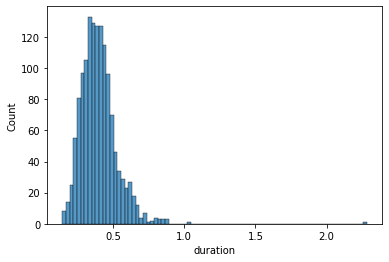

In [16]:
#plot the histogram of the duration for trian
sns.histplot(data=X_train_processed, x="duration")

In [17]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 
for i in range(0,101,10):
  percentile = np.percentile(X_train_processed["duration"].values,i)
  print("{0} th Percentile is {1}".format(i,percentile))

0 th Percentile is 0.1435374149659864
10 th Percentile is 0.2599909297052154
20 th Percentile is 0.2984308390022676
30 th Percentile is 0.3310204081632653
40 th Percentile is 0.3575238095238095
50 th Percentile is 0.38834467120181404
60 th Percentile is 0.4160362811791383
70 th Percentile is 0.44450793650793646
80 th Percentile is 0.4799818594104308
90 th Percentile is 0.5540317460317462
100 th Percentile is 2.282766439909297


In [18]:
##print 90 to 100 percentile values with step size of 1. 
for i in range(90,101,1):
  percentile = np.percentile(X_train_processed["duration"].values,i)
  print("{0} th Percentile is {1}".format(i,percentile))

90 th Percentile is 0.5540317460317462
91 th Percentile is 0.569807709750567
92 th Percentile is 0.5811446712018141
93 th Percentile is 0.5915165532879821
94 th Percentile is 0.6080870748299319
95 th Percentile is 0.622421768707483
96 th Percentile is 0.6366947845804989
97 th Percentile is 0.6574408163265306
98 th Percentile is 0.6884154195011338
99 th Percentile is 0.790681179138322
100 th Percentile is 2.282766439909297


<font size=4>Grader function 4 </font>

In [19]:
def grader_processed():
    flag_columns = (all(X_train_processed.columns==['raw_data', 'duration'])) and (all(X_test_processed.columns==['raw_data', 'duration']))
    flag_shape = (X_train_processed.shape ==(1400, 2)) and (X_test_processed.shape==(600,2))
    return flag_columns and flag_shape
grader_processed()

True

<pre>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset. 

While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640

Pad with Zero if length of sequence is less than 17640 else Truncate the number. 

Also create a masking vector for train and test. 

masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.
</pre>

In [20]:
max_length  = 17640

In [21]:
## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number. 
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask

## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.

def pad_data(data):
  max_length = 17640
  padded_seq = pad_sequences(data,maxlen=max_length, padding='post',truncating='post',dtype='float32')

  mask_arr = []
  for arr in padded_seq: 
    mask = [True if val == 0 else False for val in arr]
    mask_arr.append(np.array(mask))

  return padded_seq, np.array(mask_arr)

In [22]:
X_train_pad_seq, X_train_mask = pad_data(X_train_processed["raw_data"].values)
X_test_pad_seq, X_test_mask = pad_data(X_test_processed["raw_data"].values)

<font size=4>Grader function 5 </font>

In [23]:
def grader_padoutput():
    flag_padshape = (X_train_pad_seq.shape==(1400, 17640)) and (X_test_pad_seq.shape==(600, 17640)) and (y_train.shape==(1400,))
    flag_maskshape = (X_train_mask.shape==(1400, 17640)) and (X_test_mask.shape==(600, 17640)) and (y_test.shape==(600,))
    flag_dtype = (X_train_mask.dtype==bool) and (X_test_mask.dtype==bool)
    return flag_padshape and flag_maskshape and flag_dtype
grader_padoutput()

True

### 1. Giving Raw data directly. 

<pre>
Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. You can use any number of LSTM cells. Please read LSTM documentation(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) in tensorflow to know more about mask and also https://www.tensorflow.org/guide/keras/masking_and_padding 
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors). 
3. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients. 
4. make sure that it won't overfit. 
5. You are free to include any regularization
</pre>

In [41]:
X_test_pad_seq.shape


(600, 17640)

In [42]:
input = Input(shape=(X_train_pad_seq.shape[1],1),name="Input_Data")
input_mask = Input(shape=(X_train_mask.shape[1]), name='Input_Mask', dtype='bool')
lstm = LSTM(64)(input,mask=input_mask)
dense = Dense(32)(lstm)
output = Dense(10, activation="softmax")(dense)

In [43]:
## as discussed above, please write the LSTM
model1 = Model(inputs=[input,input_mask], outputs =[output])

In [44]:
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Data (InputLayer)         [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
Input_Mask (InputLayer)         [(None, 17640)]      0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 64)           16896       Input_Data[0][0]                 
                                                                 Input_Mask[0][0]                 
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 32)           2080        lstm_5[0][0]               

In [45]:
class Metrics_Callback(tf.keras.callbacks.Callback):
  def __init__(self,x_val,y_val):
    self.x_val = x_val
    self.y_val = y_val

  def on_train_begin(self, logs={}):
    self.history = {"micro_f1":[]}

  def on_epoch_end(self, epoch, logs={}):
    y_pred = self.model.predict(self.x_val)
    y_pred = [np.argmax(arr) for arr in y_pred]
    f1_s = f1_score(self.y_val, y_pred, average='micro')
    self.history["micro_f1"].append(f1_s)
    print('val_f1_score: ',f1_s)

micro_f1_callback = Metrics_Callback([X_test_pad_seq,X_test_mask],y_test)
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)


In [ ]:
set(y_test)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [48]:
model1.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [49]:
model1.fit([X_train_pad_seq,X_train_mask],y_train,
          epochs=5,
          batch_size=256,
          callbacks = [micro_f1_callback,tensorboard_callback],
          validation_data = ([X_test_pad_seq,X_test_mask],y_test)
          )


Epoch 1/5
6/6 [==============================] - 245s 40s/step - loss: 2.3029 - accuracy: 0.1001 - val_loss: 2.3026 - val_accuracy: 0.1000
val_f1_score:  0.10000000000000002
Epoch 2/5
6/6 [==============================] - 255s 43s/step - loss: 2.3026 - accuracy: 0.0871 - val_loss: 2.3025 - val_accuracy: 0.1000
val_f1_score:  0.10000000000000002
Epoch 3/5
6/6 [==============================] - 267s 45s/step - loss: 2.3026 - accuracy: 0.0888 - val_loss: 2.3025 - val_accuracy: 0.1000
val_f1_score:  0.10000000000000002
Epoch 4/5
6/6 [==============================] - 264s 45s/step - loss: 2.3027 - accuracy: 0.0957 - val_loss: 2.3025 - val_accuracy: 0.1000
val_f1_score:  0.10000000000000002
Epoch 5/5
6/6 [==============================] - 262s 44s/step - loss: 2.3025 - accuracy: 0.1012 - val_loss: 2.3025 - val_accuracy: 0.1000
val_f1_score:  0.10000000000000002


In [50]:
 %tensorboard --logdir logs/fit


### 2. Converting into spectrogram and giving spectrogram data as input  
<pre>
We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram
</pre>

In [51]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [52]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram = np.array([convert_to_spectrogram(x) for x in X_train_pad_seq])
X_test_spectrogram = np.array([convert_to_spectrogram(x) for x in X_test_pad_seq])


<font size=4>Grader function 6 </font>

In [53]:
def grader_spectrogram():
    flag_shape = (X_train_spectrogram.shape==(1400,64, 35)) and (X_test_spectrogram.shape == (600, 64, 35))
    return flag_shape
grader_spectrogram()

True

<pre>
Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
(ex: Output from LSTM will be  (#., time_steps, features) average the output of every time step i.e, you should get (#.,time_steps) 
and then pass to dense layer )
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  
4. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients. 
5. make sure that it won't overfit. 
6. You are free to include any regularization
</pre>

In [54]:
X_train_spectrogram.shape

(1400, 64, 35)

In [55]:
input = Input(shape=(X_train_spectrogram.shape[1],X_train_spectrogram.shape[2]),name="Input_Data")
lstm = LSTM(120,return_sequences=True)(input)
X =  tf.reduce_mean(lstm, axis=-1)
dense = Dense(128)(X)
dense2 = Dense(64)(dense)
flatten = Flatten()(dense2)
output = Dense(10, activation="softmax")(flatten)

In [56]:
model2 = Model(input, output)

In [57]:
model2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Data (InputLayer)      [(None, 64, 35)]          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64, 120)           74880     
_________________________________________________________________
tf.math.reduce_mean_4 (TFOpL (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                650 

In [59]:
class Metrics_Callback_2(tf.keras.callbacks.Callback):
  def __init__(self,x_val,y_val):
    self.x_val = x_val
    self.y_val = y_val

  def on_train_begin(self, logs={}):
    self.history = {"micro_f1":[]}

  def on_epoch_end(self, epoch, logs={}):
    y_pred = self.model.predict(self.x_val)
    y_pred = [np.argmax(arr) for arr in y_pred]
    f1_s = f1_score(self.y_val, y_pred, average='micro')
    self.history["micro_f1"].append(f1_s)
    print(' val_f1_score: ',f1_s)

micro_f1_callback = Metrics_Callback_2(X_test_spectrogram, y_test)

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

In [60]:
model2.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[
                       "accuracy"
                       ])

In [61]:
model2.fit(X_train_spectrogram,y_train,
          epochs=10,
          batch_size=32,
          callbacks = [micro_f1_callback,tensorboard_callback],
          validation_data = (X_test_spectrogram, y_test)
          )

Epoch 1/10
44/44 [==============================] - 6s 90ms/step - loss: 2.2504 - accuracy: 0.1506 - val_loss: 1.9301 - val_accuracy: 0.3067
 val_f1_score:  0.30666666666666664
Epoch 2/10
44/44 [==============================] - 3s 77ms/step - loss: 1.8447 - accuracy: 0.3625 - val_loss: 1.4271 - val_accuracy: 0.5267
 val_f1_score:  0.5266666666666666
Epoch 3/10
44/44 [==============================] - 4s 81ms/step - loss: 1.3490 - accuracy: 0.5407 - val_loss: 1.0407 - val_accuracy: 0.6267
 val_f1_score:  0.6266666666666667
Epoch 4/10
44/44 [==============================] - 3s 75ms/step - loss: 1.0156 - accuracy: 0.6576 - val_loss: 0.8490 - val_accuracy: 0.7000
 val_f1_score:  0.7
Epoch 5/10
44/44 [==============================] - 4s 80ms/step - loss: 0.8188 - accuracy: 0.7195 - val_loss: 0.7192 - val_accuracy: 0.7617
 val_f1_score:  0.7616666666666667
Epoch 6/10
44/44 [==============================] - 4s 80ms/step - loss: 0.7220 - accuracy: 0.7322 - val_loss: 0.6881 - val_accuracy: 

In [65]:
 %tensorboard --logdir logs/fit


### 3. data augmentation  
<pre>
Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.
</pre>

In [66]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [67]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [68]:
len(aug_temp)

9

As discussed above, for one data point, we will get 9 augmented data points.  

Split data into train and test (80-20 split)

We have 2000 data points(1600 train points, 400 test points) 

Do augmentation only on train data, after augmentation we will get 14400 train points. 

do the above steps i.e training with raw data and spectrogram data with augmentation.

In [69]:
X = df_audio["path"]
y = df_audio["label"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state = 45)

In [70]:
X_train_aug = []
y_train_aug = []
for fileName, y_val in zip(X_train,y_train):
  aug_data = generate_augmented_data(fileName)
  for data in aug_data:
    X_train_aug.append(data)
  # X_train_aug += 
  y_train_aug += [y_val] * 9

In [71]:
print(len(X_train_aug))
print(len(y_train_aug))

X_train_processed = pd.DataFrame(data={"raw_data":X_train_aug})
y_train = pd.DataFrame(data={"label":y_train_aug})

X_test_processed = X_test.apply(lambda x: load_wav(x,get_duration=False))

14400
14400


In [72]:
X_train_aug_pad_seq, X_train_aug_mask = pad_data(X_train_processed["raw_data"].values)
X_test_aug_pad_seq, X_test_aug_mask = pad_data(X_test_processed.values)

#### Raw data Model. 

In [73]:
input = Input(shape=(X_train_aug_pad_seq.shape[1],1),name="Input_Data")
input_mask = Input(shape=(X_train_aug_mask.shape[1]), name='Input_Mask', dtype='bool')
lstm = LSTM(64)(input,mask=input_mask)
dense = Dense(32)(lstm)
output = Dense(10, activation="softmax")(dense)

In [74]:
## as discussed above, please write the LSTM
model3 = Model(inputs=[input,input_mask], outputs =[output])

In [75]:
model3.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Data (InputLayer)         [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
Input_Mask (InputLayer)         [(None, 17640)]      0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 64)           16896       Input_Data[0][0]                 
                                                                 Input_Mask[0][0]                 
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 32)           2080        lstm_7[0][0]               

In [76]:
class Metrics_Callback(tf.keras.callbacks.Callback):
  def __init__(self,x_val,y_val):
    self.x_val = x_val
    self.y_val = y_val

  def on_train_begin(self, logs={}):
    self.history = {"micro_f1":[]}

  def on_epoch_end(self, epoch, logs={}):
    y_pred = self.model.predict(self.x_val)
    y_pred = [np.argmax(arr) for arr in y_pred]
    f1_s = f1_score(self.y_val, y_pred, average='micro')
    self.history["micro_f1"].append(f1_s)
    print(' val_f1: ',f1_s)

micro_f1_callback = Metrics_Callback([X_test_aug_pad_seq,X_test_aug_mask],y_test)

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

In [ ]:
set(y_test)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [77]:
model3.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [78]:
model3.fit([X_train_aug_pad_seq,X_train_aug_mask],y_train,
          epochs=5,
          batch_size=256,
          callbacks = [micro_f1_callback,tensorboard_callback],
          validation_data = ([X_test_aug_pad_seq,X_test_aug_mask],y_test)
          )

Epoch 1/5
12/12 [==============================] - 572s 43s/step - loss: 2.3016 - accuracy: 0.1114 - val_loss: 2.3040 - val_accuracy: 0.1000
 val_f1:  0.10000000000000002
Epoch 2/5
12/12 [==============================] - 564s 47s/step - loss: 2.2963 - accuracy: 0.1222 - val_loss: 2.3110 - val_accuracy: 0.1000
 val_f1:  0.10000000000000002
Epoch 3/5
12/12 [==============================] - 539s 45s/step - loss: 2.2925 - accuracy: 0.1353 - val_loss: 2.3120 - val_accuracy: 0.1000
 val_f1:  0.10000000000000002
Epoch 4/5
12/12 [==============================] - 524s 44s/step - loss: 2.2897 - accuracy: 0.1218 - val_loss: 2.3106 - val_accuracy: 0.1000
 val_f1:  0.10000000000000002
Epoch 5/5
12/12 [==============================] - 527s 44s/step - loss: 2.2924 - accuracy: 0.1263 - val_loss: 2.3099 - val_accuracy: 0.1000
 val_f1:  0.10000000000000002


In [85]:
 %tensorboard --logdir logs/fit


### 2. Converting into spectrogram and giving spectrogram data as input  
<pre>
We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram
</pre>

In [79]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [80]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram = np.array([convert_to_spectrogram(x) for x in X_train_aug_pad_seq])
X_test_spectrogram = np.array([convert_to_spectrogram(x) for x in X_test_aug_pad_seq])


In [81]:
input = Input(shape=(X_train_spectrogram.shape[1],X_train_spectrogram.shape[2]),name="Input_Data")
lstm = LSTM(120,return_sequences=True)(input)
X =  tf.reduce_mean(lstm, axis=-1)
dense = Dense(128)(X)
dense2 = Dense(64)(dense)
flatten = Flatten()(dense2)
output = Dense(10, activation="softmax")(flatten)

In [82]:
model4 = Model(input, output)
model4.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Data (InputLayer)      [(None, 64, 35)]          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64, 120)           74880     
_________________________________________________________________
tf.math.reduce_mean_5 (TFOpL (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                650 

In [88]:
class Metrics_Callback_2(tf.keras.callbacks.Callback):
  def __init__(self,x_val,y_val):
    self.x_val = x_val
    self.y_val = y_val

  def on_train_begin(self, logs={}):
    self.history = {"micro_f1":[]}

  def on_epoch_end(self, epoch, logs={}):
    y_pred = self.model.predict(self.x_val)
    y_pred = [np.argmax(arr) for arr in y_pred]
    f1_s = f1_score(self.y_val, y_pred, average='micro')
    self.history["micro_f1"].append(f1_s)
    print(' val_f1_score: ',f1_s)

micro_f1_callback = Metrics_Callback_2(X_test_spectrogram, y_test)

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

In [89]:
model4.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[
                       "accuracy"
                       ])

In [90]:
model4 = model4.fit(X_train_spectrogram,y_train,
          epochs=10,
          batch_size=64,
          callbacks = [micro_f1_callback, tensorboard_callback],
          validation_data = (X_test_spectrogram, y_test)
          )

Epoch 1/10
225/225 [==============================] - 23s 94ms/step - loss: 1.9063 - accuracy: 0.2948 - val_loss: 0.8202 - val_accuracy: 0.6725
 val_f1_score:  0.6725
Epoch 2/10
225/225 [==============================] - 21s 93ms/step - loss: 0.7923 - accuracy: 0.7046 - val_loss: 0.5856 - val_accuracy: 0.8100
 val_f1_score:  0.81
Epoch 3/10
225/225 [==============================] - 21s 93ms/step - loss: 0.5787 - accuracy: 0.7887 - val_loss: 0.4752 - val_accuracy: 0.8100
 val_f1_score:  0.81
Epoch 4/10
225/225 [==============================] - 21s 95ms/step - loss: 0.4836 - accuracy: 0.8251 - val_loss: 0.3597 - val_accuracy: 0.8875
 val_f1_score:  0.8875
Epoch 5/10
225/225 [==============================] - 22s 99ms/step - loss: 0.4501 - accuracy: 0.8365 - val_loss: 0.3472 - val_accuracy: 0.8675
 val_f1_score:  0.8675
Epoch 6/10
225/225 [==============================] - 22s 97ms/step - loss: 0.4164 - accuracy: 0.8474 - val_loss: 0.3616 - val_accuracy: 0.8850
 val_f1_score:  0.885
Epo

In [91]:
 %tensorboard --logdir logs/fit


In [92]:
micro_f1_callback.history

{'micro_f1': [0.6725,
  0.81,
  0.81,
  0.8875,
  0.8675,
  0.885,
  0.89,
  0.9,
  0.91,
  0.895]}

In [95]:
!jupyter nbconvert --to html "/content/Speech_detection_Assignment.ipynb" 

[NbConvertApp] Converting notebook /content/Speech_detection_Assignment.ipynb to html
[NbConvertApp] Writing 414100 bytes to /content/Speech_detection_Assignment.html
